## High Frequency Trading

### Problem Formulation
The algorithm seeks to optimize the bid ask spread for each time $t \lt T$ such that the net Profit and Loss of trading the spread is maximized at the end of the trading session time $T$. We also want to control the algorithm for excessive risk taking during the trading session. Thus, we impose two penalties: (1) running inventory penalty for trading too large exposures during the trading session, and (2) terminal inventory penalty i.e. holding non-zero inventory at the end of the trading day.  Mathematically, the maximization of stochastic system subject to the penalties is equivalent to maximizing the following objective:

$$
V(t, s_t, x_t, q_t) = \underset{\delta^{\text{b}}, \delta^{\text{a}}}{max} \ \mathbb{E} \bigg[ x_T + q_T(s_T - \alpha q_T) - \phi\int_{t}^{T}q_s^2 ds ~|~ x_t\bigg]
$$

where

- $s_t$ is the mid-price of the asset at time $t$
- $x_t$ is the market maker's cash at time $t$
- $q_t$ is the market maker's inventory at time $t$
- $\delta^{\text{b}}$ is how deep in the market we quote our bid price
- $\delta^{\text{a}}$ is how deep in the market we quote our ask price
- $\alpha > 0$ is terminal inventory penalty parameter
- $\phi > 0$ is running inventory penalty parameter

Additionally, very trade pays spread and rebate of $\epsilon$:
- If a MO hits the ask-quote of the MM: $q \to q - 1 $ and $x \to x + (S + \delta^{\text{a}}) + \epsilon$
- If a MO hits the bid-quote of the MM: $q \to q + 1 $ and $x \to x - (S - \delta^{\text{b}}) + \epsilon$

### System Dynamics

#### Incomming Order Flow
Incomming market orders at the midprice are represented via two poisson processes with parameters $\lambda_0^\text{b}$ and $\lambda_0^\text{s}$. Additionally, the further away we quote from the midprice, less likely we are to find incomming orders. Therefore, we use the following functions to model orderflow decay as we move further away from the midprice:

$$
\begin{align*}
\lambda_t(\delta^\text{b}) &= \lambda_t^\text{b} e^{-\kappa^\text{b}\delta^\text{b}} \\
\lambda_t(\delta^\text{a}) &= \lambda_t^\text{a} e^{-\kappa^\text{a}\delta^\text{a}}
\end{align*}
$$
where $\kappa^\text{b}$ and $\kappa^\text{a}$ are positive constants indicating the orderflow decay as we move further away from the mid price. as we can see this function is decreasing with an increase in $\delta$.

#### Inventory and Cash Process
Let $N^{\text{b}}_t$ and $N^{\text{a}}_t$ denote the amount of stock bought and sold respectively at time $t$, we can model the change in our inventory and cash processes as follows:

$$
\begin{align*}
dQ_t &= 
N^{\text{b}}_t - 
N^{\text{a}}_t
\\
dX_t &= 
\delta^{\text{a}}N^{\text{a}}_t +
\delta^{\text{b}}N^{\text{b}}_t
\end{align*}
$$



### Solving the control problem (HJB-QVI)
The problem above may be solved as a HJB-QVI problem where we decide between (1) market making, (2) sending a market order to buy one contract or (3) sending a market order to sell one contract. Applying standard Dynamic Programming Principle to $V(t, x_t, q_t, s_t)$ tells us that $V$ must satisfy the following HJB-QVI:

$$
\begin{align}
   0 =  max \left( 
        \frac{\partial V}{\partial t} + \underset{\delta^b, \delta^a}{max} \left[ \mathcal{L}V(t) -\phi q_t^2 \right]; 
        \mathcal{S}V - V; 
        \mathcal{B}V - V
    \right)
\end{align}
$$

where the operators $\mathcal{S}$ and $\mathcal{B}$ act on $V(t, x_t, q_t, s_t)$ such that
$$
\begin{align}
    \mathcal{S}V(t) &= V(t, x_t - \xi, q_t - 1, s_t) \\
    \mathcal{B}V(t) &= V(t, x_t - \xi, q_t + 1, s_t)
\end{align}
$$
In other words, they represent (in abstract sense) the cost of crossing the spread.

### HJB Part
We begin by examining the HJB part of the inequality: 

$$
\begin{align}
   \frac{\partial V}{\partial t} + \underset{\delta^b, \delta^a}{max} \left[ \mathcal{L}V(t) -\phi q_t^2 \right] 
\end{align}
$$

**Derivation of $\mathcal{L}V(t, x, s, q)$**:

Let's recall the definition of the infinitesimal generator:

$$
\begin{align*}
\mathcal{L}V(t, x, s, q) = \lim_{dt \to 0}\frac{\mathbb{E}\big[ \partial V(t, x, s, q) \big] }{dt}
\end{align*}
$$


We start by applying Ito's lemma to $V(t, x, s, q)$:


$$
\begin{align*}
\partial V(t, x, s, q) &= \partial_t V dt + \partial_s V dS_t + \frac{1}{2}\partial_{ss}V dS_t^2 \\
& + \big[V(t, x-(s-\delta^\text{b}) + \epsilon, s, q+1) - V(t, x, s, q) \big]dN_t^{\text{b}} \\
& + \big[V(t, x+(s+\delta^\text{a}) + \epsilon, s, q-1) - V(t, x, s, q) \big]dN_t^{\text{a}}
\end{align*}
$$


Since we assume Bachelier type model for the spot price, $dS_t = \mu dt + \sigma dW_t$ and $dS_t^2 = \sigma^2 dt$. Substituting these into the above gives:

$$
\begin{align*}
\partial V(t, x, s, q) &= \partial_t V dt + \partial_s V (\mu dt + \sigma dW_t) + \frac{1}{2}\partial_{ss}V \sigma^2 dt \\
& + \big[V(t, x-(s-\delta^\text{b}) + \epsilon, s, q+1) - V(t, x, s, q) \big]dN_t^{\text{b}} \\
& + \big[V(t, x+(s+\delta^\text{a}) + \epsilon, s, q-1) - V(t, x, s, q) \big]dN_t^{\text{a}}
\end{align*}
$$

Finally, taking expectation and dividing by $dt$ yields:

$$
\begin{align*}
\mathcal{L}V(t, x, s, q) &= \partial_t V  + \partial_s V \mu + \frac{1}{2}\partial_{ss}V \sigma^2  \\
& + \lambda_t^{\text{b}} \big[V(t, x-(s-\delta^\text{b})+ \epsilon, s, q+1) - V(t, x, s, q) \big] \\
& + \lambda_t^{\text{a}} \big[V(t, x+(s+\delta^\text{a})+ \epsilon, s, q-1) - V(t, x, s, q) \big]
\end{align*}
$$

Since we made the explicit assumption that $\lambda_t = \lambda_0 e^{-\kappa \delta}$ we get that:

$$
\begin{align*}
\mathcal{L}V(t, x, s, q) &= \partial_t V  + \partial_s V \mu + \frac{1}{2}\partial_{ss}V \sigma^2  \\
& + \lambda_0^{\text{b}} e^{-\kappa^{\text{b}} \delta^\text{b}} \big[V(t, x-(s-\delta^\text{b})+ \epsilon, s, q+1) - V(t, x, s, q) \big] \\
& + \lambda_0^{\text{a}} e^{-\kappa^{\text{a}} \delta^\text{a}} \big[V(t, x+(s+\delta^\text{a})+ \epsilon, s, q-1) - V(t, x, s, q) \big]
\end{align*}
$$


**HJB equation**:
$$
\begin{align*}
0 &= \partial_t V  + \partial_s V \mu  +  \frac{1}{2}\partial_{ss}V \sigma^2  \\
& + \underset{\delta^\text{b}}{\max} \big( \lambda_0^{\text{b}} e^{-\kappa^{\text{b}} \delta^\text{b}} \big[ V(t, x-(s-\delta^\text{b})+ \epsilon, s, q+1) - V(t, x, s, q) \big] \big) \\
& + \underset{\delta^\text{a}}{\max} \big( \lambda_0^{\text{a}} e^{-\kappa^{\text{a}} \delta^\text{a}} \big[ V(t, x+(s+\delta^\text{a})+ \epsilon, s, q-1) - V(t, x, s, q) \big] \big) \\
&- \phi q^2
\end{align*}
$$

Since the terminal cash $X_T$, is dependent on cumulative trading profits, we can simlify the PDE as follows:
$$
\begin{align*}
0 &= \partial_t V  + \partial_s V \mu  +  \frac{1}{2}\partial_{ss}V \sigma^2  \\
& + \underset{\delta^\text{b}}{\max} \big( \lambda_0^{\text{b}} e^{-\kappa^{\text{b}} \delta^\text{b}} \big[ \delta^\text{b} + \epsilon - s + V(t, s, q+1) - V(t, s, q) \big] \big) \\
& + \underset{\delta^\text{a}}{\max} \big( \lambda_0^{\text{a}} e^{-\kappa^{\text{a}} \delta^\text{a}} \big[ \delta^\text{a} + \epsilon + s + V(t, s, q-1) - V(t, s, q) \big] \big) \\
&- \phi q^2
\end{align*}
$$

We can further simplify the PDE by observing that the maximization of $\delta^\text{b}$ and $\delta^\text{a}$ is independent of $s_t$. Therefore, $V$ becomes a function of only $q$ and $t$, removing the need of our spatial derivatives with respect to $s$:
$$
\begin{align*}
0 &= \partial_t V  \\
& + \underset{\delta^\text{b}}{\max} \big( \lambda_0^{\text{b}} e^{-\kappa^{\text{b}} \delta^\text{b}} \big[ \delta^\text{b} + \epsilon + V(t, q + 1) - V(t, q) \big] \big) \\
& + \underset{\delta^\text{a}}{\max} \big( \lambda_0^{\text{a}} e^{-\kappa^{\text{a}} \delta^\text{a}} \big[ \delta^\text{a} + \epsilon + V(t, q - 1) - V(t, q) \big] \big) \\
&- \phi q^2
\end{align*}
$$

with boundry condition $V(T, q_T) = -\alpha q_T^2$.

### Calculating the Optimal Bid and Ask Depths
The optimal bid and ask quotes are calculated by solving the following optimization problems at each time step $t$:

$$
\begin{align*}
\underset{\delta^{\text{b}}}{\argmax} &\bigg[ \lambda_0^{\text{b}} e^{-\kappa^{\text{b}} \delta^{\text{b}}} \big[ \delta^{\text{b}} + \epsilon + V(t, q + 1) - V(t, q) \big] \bigg] \\

\underset{\delta^{\text{a}}}{\argmax} &\bigg[ \lambda_0^{\text{a}} e^{-\kappa^{\text{a}} \delta^{\text{a}}} \big[ \delta^{\text{a}} + \epsilon + V(t, q - 1) - V(t, q) \big] \bigg]
\end{align*}
$$

we can solve the above by differentiating with respect to $\delta^{\text{b}}$ and $\delta^{\text{a}}$ and setting the derivative to zero. Additionally we constrain our bid and ask depths to values between $0$ and $\infty$. This gives:

$$
\begin{align*}
\delta^{\text{b}} &= \max (0, \frac{1}{\kappa^{\text{b}}} - \epsilon - V(t, q + 1) + V(t, q)) \\
\delta^{\text{a}} &= \max (0, \frac{1}{\kappa^{\text{a}}} - \epsilon - V(t, q - 1) + V(t, q))
\end{align*}
$$

### Numerical Scheme
We may solve the HJB equation using a finite difference scheme by discretizing the time derivatives along with the first and second order spatial derivatives using forward and central difference schemes respectively:

$$
\begin{align*}
\partial_t V(t, q) &\approx \frac{V(t, q) - V(t - \Delta t, q)}{\Delta t}
\end{align*}
$$

Substituting this into the HJB equation gives:

$$
\begin{align*}
0 &= \frac{V(t, q) - V(t - \Delta t, q)}{\Delta t} \\
&+ \lambda_0^{\text{b}} \underset{\delta^\text{b}}{\max} \big( e^{-\kappa^{\text{b}} \delta^\text{b}} \big[\delta^\text{b}+ \epsilon + V(t, q_t + 1) - V(t, q_t) \big] \big) \\
&+ \lambda_0^{\text{a}} \underset{\delta^\text{a}}{\max} \big( e^{-\kappa^{\text{a}} \delta^\text{a}} \big[\delta^\text{a}+ \epsilon + V(t, q_t - 1) - V(t, q_t) \big] \big) \\
&- \phi q_t^2 
\end{align*}
$$

Solving for $V(t - \Delta t, q)$ gives:

$$
\begin{align*}
V(t - \Delta t, q) &= V(t, q) \\
    &+ \lambda_0^{\text{b}} \underset{\delta^\text{b}}{\max} \big( e^{-\kappa^{\text{b}} \delta^\text{b}} \big[\delta^\text{b}+ \epsilon + V(t, q_t + 1) - V(t, q_t) \big] \big)  \Delta t \\
    &+ \lambda_0^{\text{a}} \underset{\delta^\text{a}}{\max} \big( e^{-\kappa^{\text{a}} \delta^\text{a}} \big[\delta^\text{a}+ \epsilon + V(t, q_t - 1) - V(t, q_t) \big] \big)  \Delta t \\
    &- \phi q_t^2  \Delta t 
    
\end{align*}
$$

Now, we define q-grid such that $q_j \in \{q_{\text{min}}, q_{\text{min}}+1, ..., q_{\text{max}}-1, q_{\text{max}} \}$ and a t-grid where $t_i \in \{0, \Delta t, ..., T-2\Delta t, T-\Delta t, T \}$. 


The following solves $V(t_i, q_j)$ over the grid:

$$
\begin{align*}
V(t_{i-1}, q_j) &= V(t_{i}, q_j) \\
& + \mathbb{1}_{q_j < q_{\text{max}}}\lambda_0^\text{b} \underset{\delta^\text{b}}{\max} \left( e^{-\kappa^\text{b} \delta^\text{b}} \left[ \delta^\text{b}+ \epsilon + V(t_i, q_j + 1) - V(t_i, q_j) \right] \right)\Delta t \\
& + \mathbb{1}_{q_j > q_{\text{min}}}\lambda_0^\text{a} \underset{\delta^\text{a}}{\max} \left( e^{-\kappa^\text{a} \delta^\text{a}}\left[ \delta^\text{a}+ \epsilon + V(t_i, q_j - 1) - V(t_i, q_j) \right]\right)\Delta t \\
&- \phi q_j^2 \Delta t
\end{align*}
$$

Additionally at each time step $t_i$, we need to consider the maximum between our original three options:

$$
\begin{align}
    V(t_i, q_t) = \max \{ V(t_{i}, q_j); \mathcal{S}V(t_{i}, q_j) ;\mathcal{B}V(t_{i}, q_j)\}
\end{align}
$$

Due to the overlapping nature of the above equations, we will solve the inequality using an iterative scheme where we update the value of $V(t_i, q_j)$ at each time step $t_i$ until convergence.

### Algorithm

$$\begin{align*}

&\text{Input: } \text{Market Parameters} = \{\lambda_0^\text{b}, \lambda_0^\text{a}, \kappa^\text{b}, \kappa^\text{a}, \epsilon, \xi, \phi, \alpha, q_{\text{min}}, q_{\text{max}}, T, N\}\\

&\text{Output: } \text{The Optimal Value Function} = V(t, q)\\\\

&\text{Initialize: } \Delta t = \frac{T}{N}, T=\{0, \Delta t, 2\Delta t, \ldots, T\}, Q=\{q_{\text{min}}, q_{\text{min}}+1, \ldots, q_{\text{max}}\}, V(T, q) = -\phi q^2\\
\\
&\textbf{for } t_i = (T-\Delta t) \to 0 \text{ do:}\\
&\quad \Delta \leftarrow \infty \\
&\quad V' \leftarrow 0\\\\

&\quad \textbf{while } \Delta \gt \Delta_{\text{min}} \text{ do:}\\
&\quad \quad \textbf{for } q_j \in Q \text{ do}\\
&\quad \quad \quad \delta^\text{b} \leftarrow \max \bigg(0, \frac{1}{\kappa^{\text{b}}} - \epsilon - V(t, q + 1) + V(t, q)\bigg)\\
&\quad \quad \quad \delta^\text{a} \leftarrow \max \bigg(0, \frac{1}{\kappa^{\text{a}}} - \epsilon - V(t, q - 1) + V(t, q)\bigg)\\
&\quad \quad \quad V_\mathcal{B}(t_{i-1}, q_j) \leftarrow V(t_{i - 1}, q_{j} + 1) - \xi \\
&\quad \quad \quad V_\mathcal{S}(t_{i-1}, q_j) \leftarrow V(t_{i - 1}, q_{j} - 1) - \xi \\\\

&\quad \quad \quad \textbf{if } q = q_\text{min} \textbf{ then:}\\
&\quad \quad \quad \quad V_\mathcal{M}(t_{i-1}, q_j) \leftarrow V(t_{i}, q_j) - \phi q_j^2 \Delta t\\
    &\quad \quad \quad \quad \quad \quad + \lambda_0^\text{b} \left( e^{-\kappa^\text{b} \delta^\text{b}} \left[ \delta^\text{b}+ \epsilon + V(t_i, q_j + 1) - V(t_i, q_j) \right] \right)\Delta t \\
&\quad \quad \quad \quad V'(t_i, q_j) \leftarrow \max(V_\mathcal{B}(t_{i-1}, q_j), V_\mathcal{M}(t_{i-1}, q_j))\\\\

&\quad \quad \quad \textbf{if } q = q_\text{max} \textbf{ then:}\\
&\quad \quad \quad \quad V_\mathcal{M}(t_{i-1}, q_j) \leftarrow V(t_{i}, q_j) - \phi q_j^2 \Delta t\\
    &\quad \quad \quad \quad \quad \quad + \lambda_0^\text{a} \left( e^{-\kappa^\text{a} \delta^\text{a}} \left[ \delta^\text{a}+ \epsilon + V(t_i, q_j - 1) - V(t_i, q_j) \right]\right)\Delta t \\
&\quad \quad \quad \quad V'(t_i, q_j) \leftarrow \max(V_\mathcal{S}(t_{i-1}, q_j), V_\mathcal{M}(t_{i-1}, q_j))\\\\

&\quad \quad \quad \textbf{if } q_\text{min} < q < q_\text{max} \textbf{ then:}\\
&\quad \quad \quad \quad V_\mathcal{M}(t_{i-1}, q_j) \leftarrow V(t_{i}, q_j) - \phi q_j^2 \Delta t\\
    &\quad \quad \quad \quad \quad \quad + \lambda_0^\text{b} \left( e^{-\kappa^\text{b} \delta^\text{b}} \left[ \delta^\text{b}+ \epsilon + V(t_i, q_j + 1) - V(t_i, q_j) \right] \right)\Delta t \\
    &\quad \quad \quad \quad \quad \quad + \lambda_0^\text{a} \left( e^{-\kappa^\text{a} \delta^\text{a}} \left[ \delta^\text{a}+ \epsilon + V(t_i, q_j - 1) - V(t_i, q_j) \right]\right)\Delta t \\
&\quad \quad \quad \quad V'(t_i, q_j) \leftarrow \max(V_\mathcal{B}(t_{i-1}, q_j), V_\mathcal{S}(t_{i-1}, q_j), V_\mathcal{M}(t_{i-1}, q_j))\\\\

& \quad \quad \Delta \leftarrow  \| V'(t_i, q_j) - V(t_i, q_j) \| \\
& \quad \quad V \leftarrow V'\\\\

&\quad \text{Return: } V(t, q)\\

\end{align*}
$$

### Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src import MarketMaker

In [2]:
lambda_bid = 50     # Number of market order arrivals per minute on the bid
lambda_ask = 50     # Number of market order arrivals per minute on the ask
kappa_bid = 100     # Decay parameter for "fill rate" on the bid
kappa_ask = 100     # Decay parameter for "fill rate" on the ask

phi = 1e-6          # running inventory penalty parameter
alpha = 1e-4        # terminal inventory penalty parameter

q_min = -50         # largest allowed short position
q_max = 50          # largest allowed long position

rebate = 0.0025     # rebate rate for providing liquidity
cost = 0.005        # cost for taking liquidity

T = 5               # 5 minutes
N = T * 60          # one step per second

In [3]:
mm = MarketMaker()
mm.solve_hjb_qvi(lambda_bid, lambda_ask, kappa_bid, kappa_ask, rebate, cost, phi, alpha, T, N, q_min, q_max)
value_function = mm.V

Solving HJB-QVI...


100%|██████████| 300/300 [00:03<00:00, 99.47it/s] 


### Results

#### Value Function

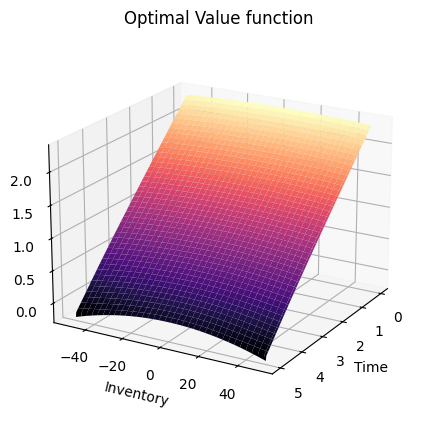

In [4]:
# Plot the value function
X = value_function.t_grid
Y = value_function.q_grid
X, Y = np.meshgrid(X, Y)


f = plt.figure(figsize=[5, 5])
pp3d = plt.axes(projection="3d", elev=20, azim=30)
pp3d.set_title("Optimal Value function")
pp3d.set_xlabel("Time")
pp3d.set_ylabel("Inventory")
pp3d.set_zlabel("Optimal Value")
pp3d.plot_surface(X, Y, value_function.V.T, cmap='magma')


plt.show()